[View in Colaboratory](https://colab.research.google.com/github/karangautam/Learning-Samples/blob/master/Credit_Card_Fraud_Detection.ipynb)

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

Using TensorFlow backend.


In [2]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karangautam","key":"7886fb75a6cbe6a3bf59d84dcbab4904"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 67 Aug  5 10:01 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 /content/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 85%|████████████████████████████████▎     | 56.0M/66.0M [00:00<00:00, 75.8MB/s]
100%|███████████████████████████████████████| 66.0M/66.0M [00:00<00:00, 110MB/s]


In [7]:
from subprocess import check_output
print(check_output(["ls", "../content/"]).decode("utf8"))
#print(check_output(["ls", "../content/.kaggle/competitions/whale-categorization-playground/train/train"]).decode("utf8"))

creditcard.csv
creditcardfraud.zip
datalab
kaggle.json



In [0]:
df = pd.read_csv("../content/creditcard.csv")

In [9]:
df.shape

(284807, 31)

In [10]:
df.isnull().values.any()

False

In [11]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


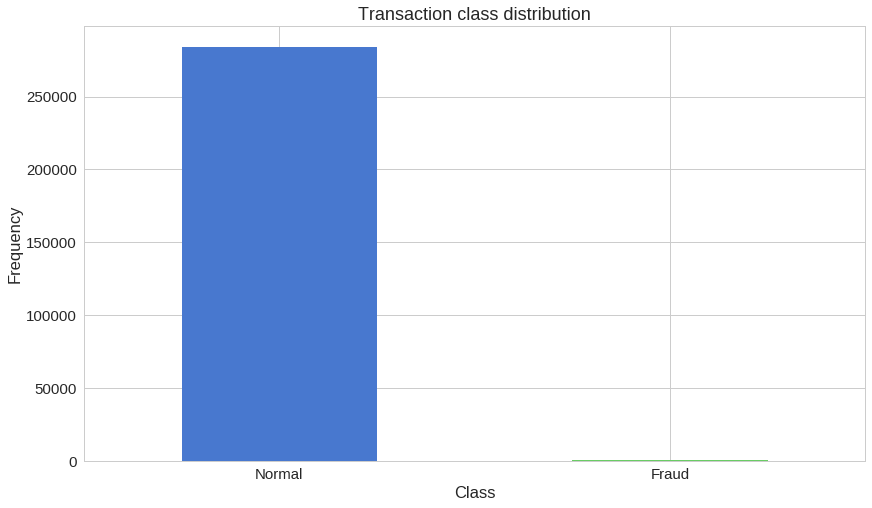

In [12]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [0]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [14]:
frauds.shape

(492, 31)

In [15]:
normal.shape

(284315, 31)

In [16]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [17]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

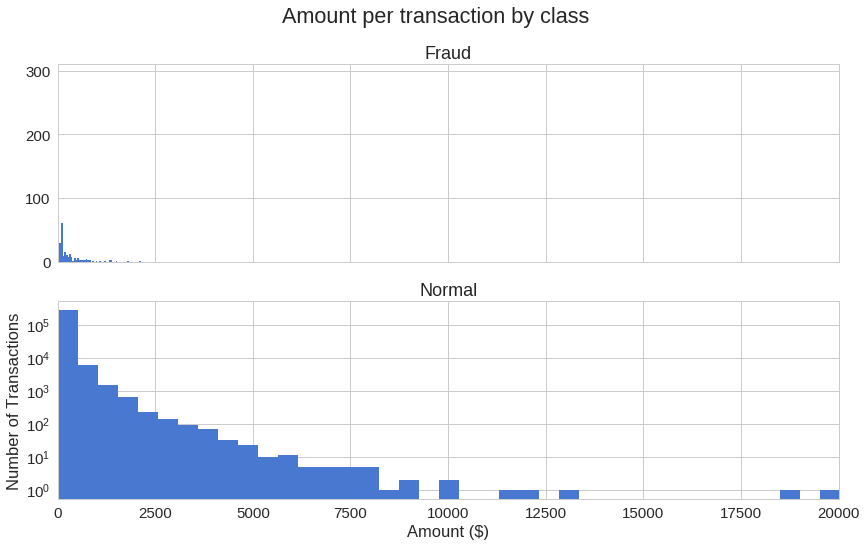

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

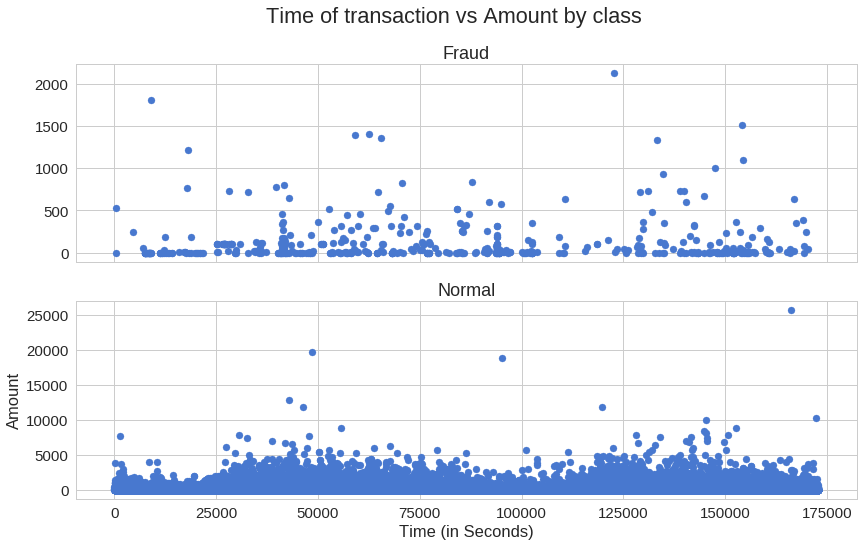

In [19]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [0]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [22]:
X_train.shape

(227451, 29)

In [24]:
X_train[2:10]

array([[ 7.25090164e-02,  8.20565650e-01, -5.61350916e-01,
        -7.09896721e-01,  1.08039936e+00, -3.59429496e-01,
         7.87857599e-01,  1.17275614e-01, -1.31275441e-01,
        -6.38222149e-01,  5.21930562e-01, -7.27681926e-02,
        -1.00823672e+00, -6.40248865e-01, -8.01945965e-01,
         6.78131225e-01,  4.43744442e-02,  5.21918858e-01,
         1.98772253e-01,  1.22269345e-02, -3.14638250e-01,
        -8.72959380e-01,  8.33909739e-02,  1.48178486e-01,
        -4.31459044e-01,  1.19689579e-01,  2.06394866e-01,
         7.02877702e-02, -3.05292340e-01],
       [-5.35045381e-01,  1.01458675e+00,  1.75067891e+00,
         2.76938952e+00,  5.00089057e-01,  1.00227002e+00,
         8.47902452e-01, -8.13227731e-02,  3.71579191e-01,
         5.60595475e-01, -8.55436772e-01, -4.17962754e+00,
         2.86872063e-01,  1.27125440e+00, -1.01164683e+00,
         1.45859955e+00, -6.13259974e-01,  8.14930899e-01,
        -2.14712434e+00, -2.53757467e-01,  6.35250013e-02,
         4.43

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [0]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [27]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
164704/227451 [====================>.........] - ETA: 13s - loss: 0.8467 - acc: 0.5824

227451/227451 [==============================] - 53s 233us/step - loss: 0.8224 - acc: 0.6007 - val_loss: 0.7981 - val_acc: 0.6509
Epoch 2/100
 84000/227451 [==========>...................] - ETA: 31s - loss: 0.7613 - acc: 0.6503

227451/227451 [==============================] - 53s 231us/step - loss: 0.7554 - acc: 0.6551 - val_loss: 0.7784 - val_acc: 0.6560
Epoch 3/100
 53536/227451 [======>.......................] - ETA: 38s - loss: 0.7367 - acc: 0.6621

227451/227451 [==============================] - 53s 232us/step - loss: 0.7424 - acc: 0.6622 - val_loss: 0.7698 - val_acc: 0.6660
Epoch 4/100
 41536/227451 [====>.........................] - ETA: 40s - loss: 0.7677 - acc: 0.6614

227451/227451 [==============================] - 53s 231us/step - loss: 0.7366 - acc: 0.6646 - val_loss: 0.7664 - val_acc: 0.6643
Epoch 5/100
 37856/227451 [===>..........................] - ETA: 40s - loss: 0.7050 - acc: 0.6603

227451/227451 [==============================] - 53s 231us/step - loss: 0.7334 - acc: 0.6643 - val_loss: 0.7673 - val_acc: 0.6604
Epoch 6/100
 36160/227451 [===>..........................] - ETA: 41s - loss: 0.7299 - acc: 0.6611

227451/227451 [==============================] - 53s 232us/step - loss: 0.7312 - acc: 0.6643 - val_loss: 0.7611 - val_acc: 0.6680
Epoch 7/100
 35072/227451 [===>..........................] - ETA: 42s - loss: 0.7327 - acc: 0.6651

227451/227451 [==============================] - 53s 231us/step - loss: 0.7297 - acc: 0.6674 - val_loss: 0.7648 - val_acc: 0.6655
Epoch 8/100
 35552/227451 [===>..........................] - ETA: 41s - loss: 0.7336 - acc: 0.6700

227451/227451 [==============================] - 53s 234us/step - loss: 0.7280 - acc: 0.6704 - val_loss: 0.7596 - val_acc: 0.6776
Epoch 9/100
 33888/227451 [===>..........................] - ETA: 42s - loss: 0.7273 - acc: 0.6706

227451/227451 [==============================] - 53s 232us/step - loss: 0.7271 - acc: 0.6718 - val_loss: 0.7584 - val_acc: 0.6754
Epoch 10/100
 35392/227451 [===>..........................] - ETA: 41s - loss: 0.7487 - acc: 0.6726

227451/227451 [==============================] - 51s 226us/step - loss: 0.7262 - acc: 0.6728 - val_loss: 0.7576 - val_acc: 0.6797
Epoch 11/100
 37248/227451 [===>..........................] - ETA: 40s - loss: 0.7313 - acc: 0.6747

227451/227451 [==============================] - 51s 225us/step - loss: 0.7253 - acc: 0.6743 - val_loss: 0.7570 - val_acc: 0.6703
Epoch 12/100
 38464/227451 [====>.........................] - ETA: 39s - loss: 0.7149 - acc: 0.6797

227451/227451 [==============================] - 52s 229us/step - loss: 0.7249 - acc: 0.6752 - val_loss: 0.7594 - val_acc: 0.6652
Epoch 13/100
 36096/227451 [===>..........................] - ETA: 42s - loss: 0.6950 - acc: 0.6781

227451/227451 [==============================] - 54s 235us/step - loss: 0.7244 - acc: 0.6758 - val_loss: 0.7576 - val_acc: 0.6679
Epoch 14/100
 33152/227451 [===>..........................] - ETA: 43s - loss: 0.7227 - acc: 0.6736

227451/227451 [==============================] - 54s 236us/step - loss: 0.7239 - acc: 0.6760 - val_loss: 0.7566 - val_acc: 0.6817
Epoch 15/100
 33120/227451 [===>..........................] - ETA: 42s - loss: 0.7127 - acc: 0.6763

227451/227451 [==============================] - 53s 234us/step - loss: 0.7236 - acc: 0.6761 - val_loss: 0.7539 - val_acc: 0.6841
Epoch 16/100
 33664/227451 [===>..........................] - ETA: 42s - loss: 0.7106 - acc: 0.6756

227451/227451 [==============================] - 53s 234us/step - loss: 0.7231 - acc: 0.6772 - val_loss: 0.7597 - val_acc: 0.6753
Epoch 17/100
 33504/227451 [===>..........................] - ETA: 42s - loss: 0.7288 - acc: 0.6742

227451/227451 [==============================] - 54s 236us/step - loss: 0.7229 - acc: 0.6769 - val_loss: 0.7541 - val_acc: 0.6847
Epoch 18/100
 33120/227451 [===>..........................] - ETA: 42s - loss: 0.7107 - acc: 0.6791

227451/227451 [==============================] - 53s 235us/step - loss: 0.7225 - acc: 0.6767 - val_loss: 0.7551 - val_acc: 0.6752
Epoch 19/100
 32608/227451 [===>..........................] - ETA: 43s - loss: 0.7242 - acc: 0.6789

227451/227451 [==============================] - 54s 235us/step - loss: 0.7219 - acc: 0.6780 - val_loss: 0.7546 - val_acc: 0.6733
Epoch 20/100
 32032/227451 [===>..........................] - ETA: 43s - loss: 0.7619 - acc: 0.6779

227451/227451 [==============================] - 54s 238us/step - loss: 0.7218 - acc: 0.6771 - val_loss: 0.7557 - val_acc: 0.6803
Epoch 21/100
 30912/227451 [===>..........................] - ETA: 43s - loss: 0.7143 - acc: 0.6771

227451/227451 [==============================] - 54s 236us/step - loss: 0.7217 - acc: 0.6779 - val_loss: 0.7534 - val_acc: 0.6795
Epoch 22/100
 31488/227451 [===>..........................] - ETA: 43s - loss: 0.7008 - acc: 0.6792

227451/227451 [==============================] - 53s 235us/step - loss: 0.7212 - acc: 0.6774 - val_loss: 0.7539 - val_acc: 0.6744
Epoch 23/100
 33152/227451 [===>..........................] - ETA: 41s - loss: 0.7001 - acc: 0.6773

227451/227451 [==============================] - 53s 234us/step - loss: 0.7210 - acc: 0.6786 - val_loss: 0.7573 - val_acc: 0.6750
Epoch 24/100
 32608/227451 [===>..........................] - ETA: 43s - loss: 0.7206 - acc: 0.6793

227451/227451 [==============================] - 54s 236us/step - loss: 0.7214 - acc: 0.6784 - val_loss: 0.7528 - val_acc: 0.6809
Epoch 25/100
 31968/227451 [===>..........................] - ETA: 43s - loss: 0.7152 - acc: 0.6774

227451/227451 [==============================] - 54s 238us/step - loss: 0.7208 - acc: 0.6789 - val_loss: 0.7548 - val_acc: 0.6824
Epoch 26/100
 31552/227451 [===>..........................] - ETA: 43s - loss: 0.7159 - acc: 0.6800

227451/227451 [==============================] - 53s 234us/step - loss: 0.7206 - acc: 0.6781 - val_loss: 0.7550 - val_acc: 0.6796
Epoch 27/100
 31616/227451 [===>..........................] - ETA: 43s - loss: 0.7038 - acc: 0.6760

227451/227451 [==============================] - 54s 240us/step - loss: 0.7210 - acc: 0.6791 - val_loss: 0.7523 - val_acc: 0.6839
Epoch 28/100
 30080/227451 [==>...........................] - ETA: 43s - loss: 0.7391 - acc: 0.6761

227451/227451 [==============================] - 54s 238us/step - loss: 0.7205 - acc: 0.6786 - val_loss: 0.7521 - val_acc: 0.6734
Epoch 29/100
 29792/227451 [==>...........................] - ETA: 44s - loss: 0.6992 - acc: 0.6811

227451/227451 [==============================] - 54s 237us/step - loss: 0.7205 - acc: 0.6791 - val_loss: 0.7517 - val_acc: 0.6883
Epoch 30/100
 30208/227451 [==>...........................] - ETA: 43s - loss: 0.7387 - acc: 0.6795

227451/227451 [==============================] - 54s 239us/step - loss: 0.7201 - acc: 0.6794 - val_loss: 0.7554 - val_acc: 0.6752
Epoch 31/100
 28608/227451 [==>...........................] - ETA: 45s - loss: 0.7180 - acc: 0.6838

227451/227451 [==============================] - 54s 239us/step - loss: 0.7201 - acc: 0.6790 - val_loss: 0.7533 - val_acc: 0.6877
Epoch 32/100
 29376/227451 [==>...........................] - ETA: 43s - loss: 0.6970 - acc: 0.6840

227451/227451 [==============================] - 54s 239us/step - loss: 0.7197 - acc: 0.6790 - val_loss: 0.7516 - val_acc: 0.6830
Epoch 33/100
 29408/227451 [==>...........................] - ETA: 43s - loss: 0.7246 - acc: 0.6739

227451/227451 [==============================] - 54s 237us/step - loss: 0.7200 - acc: 0.6794 - val_loss: 0.7520 - val_acc: 0.6828
Epoch 34/100
 29920/227451 [==>...........................] - ETA: 44s - loss: 0.7110 - acc: 0.6781

227451/227451 [==============================] - 55s 240us/step - loss: 0.7196 - acc: 0.6787 - val_loss: 0.7519 - val_acc: 0.6873
Epoch 35/100
 28832/227451 [==>...........................] - ETA: 44s - loss: 0.7159 - acc: 0.6776

227451/227451 [==============================] - 54s 239us/step - loss: 0.7202 - acc: 0.6792 - val_loss: 0.7556 - val_acc: 0.6761
Epoch 36/100
 28544/227451 [==>...........................] - ETA: 44s - loss: 0.7756 - acc: 0.6787

227451/227451 [==============================] - 53s 235us/step - loss: 0.7199 - acc: 0.6779 - val_loss: 0.7575 - val_acc: 0.6694
Epoch 37/100
 31296/227451 [===>..........................] - ETA: 43s - loss: 0.6944 - acc: 0.6802

227451/227451 [==============================] - 54s 237us/step - loss: 0.7191 - acc: 0.6792 - val_loss: 0.7515 - val_acc: 0.6700
Epoch 38/100
 30112/227451 [==>...........................] - ETA: 44s - loss: 0.6961 - acc: 0.6809

227451/227451 [==============================] - 54s 239us/step - loss: 0.7195 - acc: 0.6790 - val_loss: 0.7528 - val_acc: 0.6749
Epoch 39/100
 29952/227451 [==>...........................] - ETA: 43s - loss: 0.7168 - acc: 0.6747

227451/227451 [==============================] - 54s 238us/step - loss: 0.7190 - acc: 0.6794 - val_loss: 0.7511 - val_acc: 0.6814
Epoch 40/100
 29536/227451 [==>...........................] - ETA: 44s - loss: 0.7218 - acc: 0.6812

227451/227451 [==============================] - 54s 237us/step - loss: 0.7189 - acc: 0.6794 - val_loss: 0.7539 - val_acc: 0.6758
Epoch 41/100
 31072/227451 [===>..........................] - ETA: 42s - loss: 0.7354 - acc: 0.6767

227451/227451 [==============================] - 53s 234us/step - loss: 0.7190 - acc: 0.6784 - val_loss: 0.7562 - val_acc: 0.6798
Epoch 42/100
 32256/227451 [===>..........................] - ETA: 43s - loss: 0.7400 - acc: 0.6785

227451/227451 [==============================] - 54s 239us/step - loss: 0.7189 - acc: 0.6793 - val_loss: 0.7537 - val_acc: 0.6800
Epoch 43/100
 29920/227451 [==>...........................] - ETA: 44s - loss: 0.6889 - acc: 0.6806

227451/227451 [==============================] - 54s 237us/step - loss: 0.7191 - acc: 0.6796 - val_loss: 0.7496 - val_acc: 0.6851
Epoch 44/100
 30400/227451 [===>..........................] - ETA: 43s - loss: 0.7129 - acc: 0.6792

227451/227451 [==============================] - 54s 236us/step - loss: 0.7189 - acc: 0.6793 - val_loss: 0.7500 - val_acc: 0.6833
Epoch 45/100
 30880/227451 [===>..........................] - ETA: 43s - loss: 0.6911 - acc: 0.6800

227451/227451 [==============================] - 53s 235us/step - loss: 0.7188 - acc: 0.6799 - val_loss: 0.7513 - val_acc: 0.6781
Epoch 46/100
 32608/227451 [===>..........................] - ETA: 43s - loss: 0.7308 - acc: 0.6774

227451/227451 [==============================] - 53s 233us/step - loss: 0.7187 - acc: 0.6794 - val_loss: 0.7570 - val_acc: 0.6809
Epoch 47/100
 34528/227451 [===>..........................] - ETA: 42s - loss: 0.7140 - acc: 0.6836

227451/227451 [==============================] - 54s 236us/step - loss: 0.7189 - acc: 0.6795 - val_loss: 0.7500 - val_acc: 0.6788
Epoch 48/100
 32000/227451 [===>..........................] - ETA: 43s - loss: 0.6811 - acc: 0.6787

227451/227451 [==============================] - 54s 236us/step - loss: 0.7184 - acc: 0.6799 - val_loss: 0.7492 - val_acc: 0.6796
Epoch 49/100
 30688/227451 [===>..........................] - ETA: 44s - loss: 0.7854 - acc: 0.6774

227451/227451 [==============================] - 55s 240us/step - loss: 0.7187 - acc: 0.6794 - val_loss: 0.7500 - val_acc: 0.6896
Epoch 50/100
 28128/227451 [==>...........................] - ETA: 45s - loss: 0.7076 - acc: 0.6801

227451/227451 [==============================] - 54s 238us/step - loss: 0.7185 - acc: 0.6803 - val_loss: 0.7496 - val_acc: 0.6797
Epoch 51/100
 29248/227451 [==>...........................] - ETA: 44s - loss: 0.7070 - acc: 0.6817

227451/227451 [==============================] - 54s 237us/step - loss: 0.7191 - acc: 0.6796 - val_loss: 0.7511 - val_acc: 0.6887
Epoch 52/100
 29472/227451 [==>...........................] - ETA: 44s - loss: 0.7344 - acc: 0.6758

227451/227451 [==============================] - 55s 240us/step - loss: 0.7185 - acc: 0.6800 - val_loss: 0.7505 - val_acc: 0.6841
Epoch 53/100
 28416/227451 [==>...........................] - ETA: 44s - loss: 0.6926 - acc: 0.6794

227451/227451 [==============================] - 54s 238us/step - loss: 0.7186 - acc: 0.6802 - val_loss: 0.7577 - val_acc: 0.6810
Epoch 54/100
 29152/227451 [==>...........................] - ETA: 44s - loss: 0.6918 - acc: 0.6789

227451/227451 [==============================] - 54s 240us/step - loss: 0.7184 - acc: 0.6791 - val_loss: 0.7504 - val_acc: 0.6735
Epoch 55/100
 29056/227451 [==>...........................] - ETA: 44s - loss: 0.7705 - acc: 0.6762

227451/227451 [==============================] - 54s 237us/step - loss: 0.7186 - acc: 0.6793 - val_loss: 0.7498 - val_acc: 0.6883
Epoch 56/100
 29568/227451 [==>...........................] - ETA: 44s - loss: 0.7307 - acc: 0.6749

227451/227451 [==============================] - 57s 252us/step - loss: 0.7178 - acc: 0.6794 - val_loss: 0.7513 - val_acc: 0.6759
Epoch 57/100
 25248/227451 [==>...........................] - ETA: 45s - loss: 0.7209 - acc: 0.6808

227451/227451 [==============================] - 54s 238us/step - loss: 0.7184 - acc: 0.6798 - val_loss: 0.7506 - val_acc: 0.6849
Epoch 58/100
 27168/227451 [==>...........................] - ETA: 46s - loss: 0.7162 - acc: 0.6814

227451/227451 [==============================] - 54s 237us/step - loss: 0.7181 - acc: 0.6802 - val_loss: 0.7544 - val_acc: 0.6736
Epoch 59/100
 30304/227451 [==>...........................] - ETA: 43s - loss: 0.7843 - acc: 0.6813

227451/227451 [==============================] - 54s 236us/step - loss: 0.7184 - acc: 0.6798 - val_loss: 0.7505 - val_acc: 0.6895
Epoch 60/100
 31200/227451 [===>..........................] - ETA: 43s - loss: 0.7295 - acc: 0.6803

227451/227451 [==============================] - 54s 239us/step - loss: 0.7186 - acc: 0.6788 - val_loss: 0.7526 - val_acc: 0.6749
Epoch 61/100
 30240/227451 [==>...........................] - ETA: 44s - loss: 0.7252 - acc: 0.6804

227451/227451 [==============================] - 55s 240us/step - loss: 0.7181 - acc: 0.6803 - val_loss: 0.7486 - val_acc: 0.6795
Epoch 62/100
 29376/227451 [==>...........................] - ETA: 44s - loss: 0.6971 - acc: 0.6807

227451/227451 [==============================] - 54s 237us/step - loss: 0.7178 - acc: 0.6806 - val_loss: 0.7502 - val_acc: 0.6798
Epoch 63/100
 29376/227451 [==>...........................] - ETA: 44s - loss: 0.6991 - acc: 0.6795

227451/227451 [==============================] - 54s 239us/step - loss: 0.7180 - acc: 0.6800 - val_loss: 0.7495 - val_acc: 0.6804
Epoch 64/100
 28960/227451 [==>...........................] - ETA: 44s - loss: 0.7961 - acc: 0.6747

227451/227451 [==============================] - 54s 239us/step - loss: 0.7179 - acc: 0.6802 - val_loss: 0.7503 - val_acc: 0.6890
Epoch 65/100
 28544/227451 [==>...........................] - ETA: 44s - loss: 0.7107 - acc: 0.6831

227451/227451 [==============================] - 55s 242us/step - loss: 0.7179 - acc: 0.6803 - val_loss: 0.7502 - val_acc: 0.6795
Epoch 66/100
 27360/227451 [==>...........................] - ETA: 45s - loss: 0.7076 - acc: 0.6749

227451/227451 [==============================] - 54s 239us/step - loss: 0.7182 - acc: 0.6789 - val_loss: 0.7506 - val_acc: 0.6812
Epoch 67/100
 28416/227451 [==>...........................] - ETA: 44s - loss: 0.7150 - acc: 0.6795

227451/227451 [==============================] - 55s 241us/step - loss: 0.7181 - acc: 0.6801 - val_loss: 0.7491 - val_acc: 0.6852
Epoch 68/100
 28128/227451 [==>...........................] - ETA: 44s - loss: 0.7087 - acc: 0.6785

227451/227451 [==============================] - 54s 239us/step - loss: 0.7179 - acc: 0.6798 - val_loss: 0.7494 - val_acc: 0.6881
Epoch 69/100
 28608/227451 [==>...........................] - ETA: 44s - loss: 0.7109 - acc: 0.6861

227451/227451 [==============================] - 54s 239us/step - loss: 0.7178 - acc: 0.6800 - val_loss: 0.7505 - val_acc: 0.6829
Epoch 70/100
 29344/227451 [==>...........................] - ETA: 44s - loss: 0.7007 - acc: 0.6824

227451/227451 [==============================] - 54s 239us/step - loss: 0.7182 - acc: 0.6799 - val_loss: 0.7501 - val_acc: 0.6784
Epoch 71/100
 28576/227451 [==>...........................] - ETA: 44s - loss: 0.7494 - acc: 0.6793

227451/227451 [==============================] - 55s 240us/step - loss: 0.7176 - acc: 0.6802 - val_loss: 0.7532 - val_acc: 0.6801
Epoch 72/100
 28800/227451 [==>...........................] - ETA: 44s - loss: 0.6946 - acc: 0.6727

227451/227451 [==============================] - 54s 237us/step - loss: 0.7177 - acc: 0.6798 - val_loss: 0.7492 - val_acc: 0.6854
Epoch 73/100
 29888/227451 [==>...........................] - ETA: 43s - loss: 0.6735 - acc: 0.6805

227451/227451 [==============================] - 55s 240us/step - loss: 0.7179 - acc: 0.6794 - val_loss: 0.7528 - val_acc: 0.6758
Epoch 74/100
 28000/227451 [==>...........................] - ETA: 45s - loss: 0.7631 - acc: 0.6813

227451/227451 [==============================] - 54s 239us/step - loss: 0.7173 - acc: 0.6795 - val_loss: 0.7489 - val_acc: 0.6772
Epoch 75/100
 28256/227451 [==>...........................] - ETA: 45s - loss: 0.7102 - acc: 0.6803

227451/227451 [==============================] - 55s 240us/step - loss: 0.7179 - acc: 0.6788 - val_loss: 0.7498 - val_acc: 0.6683
Epoch 76/100
 28704/227451 [==>...........................] - ETA: 44s - loss: 0.7151 - acc: 0.6823

227451/227451 [==============================] - 54s 238us/step - loss: 0.7174 - acc: 0.6791 - val_loss: 0.7534 - val_acc: 0.6773
Epoch 77/100
 30016/227451 [==>...........................] - ETA: 43s - loss: 0.6712 - acc: 0.6819

227451/227451 [==============================] - 54s 238us/step - loss: 0.7180 - acc: 0.6795 - val_loss: 0.7485 - val_acc: 0.6813
Epoch 78/100
 29888/227451 [==>...........................] - ETA: 43s - loss: 0.7135 - acc: 0.6831

227451/227451 [==============================] - 54s 237us/step - loss: 0.7173 - acc: 0.6799 - val_loss: 0.7482 - val_acc: 0.6865
Epoch 79/100
 30048/227451 [==>...........................] - ETA: 44s - loss: 0.6868 - acc: 0.6785

227451/227451 [==============================] - 54s 238us/step - loss: 0.7174 - acc: 0.6796 - val_loss: 0.7503 - val_acc: 0.6850
Epoch 80/100
 30304/227451 [==>...........................] - ETA: 44s - loss: 0.6941 - acc: 0.6769

227451/227451 [==============================] - 54s 235us/step - loss: 0.7174 - acc: 0.6791 - val_loss: 0.7497 - val_acc: 0.6885
Epoch 81/100
 30912/227451 [===>..........................] - ETA: 44s - loss: 0.6986 - acc: 0.6834

227451/227451 [==============================] - 54s 239us/step - loss: 0.7175 - acc: 0.6802 - val_loss: 0.7512 - val_acc: 0.6776
Epoch 82/100
 29920/227451 [==>...........................] - ETA: 44s - loss: 0.7148 - acc: 0.6822

227451/227451 [==============================] - 54s 239us/step - loss: 0.7170 - acc: 0.6804 - val_loss: 0.7491 - val_acc: 0.6787
Epoch 83/100
 29536/227451 [==>...........................] - ETA: 44s - loss: 0.7304 - acc: 0.6768

227451/227451 [==============================] - 54s 239us/step - loss: 0.7172 - acc: 0.6788 - val_loss: 0.7522 - val_acc: 0.6807
Epoch 84/100
 29056/227451 [==>...........................] - ETA: 44s - loss: 0.7225 - acc: 0.6805

227451/227451 [==============================] - 53s 234us/step - loss: 0.7172 - acc: 0.6796 - val_loss: 0.7532 - val_acc: 0.6732
Epoch 85/100
 31040/227451 [===>..........................] - ETA: 43s - loss: 0.7045 - acc: 0.6797

227451/227451 [==============================] - 54s 238us/step - loss: 0.7167 - acc: 0.6802 - val_loss: 0.7539 - val_acc: 0.6720
Epoch 86/100
 29728/227451 [==>...........................] - ETA: 44s - loss: 0.6946 - acc: 0.6819

227451/227451 [==============================] - 54s 237us/step - loss: 0.7174 - acc: 0.6792 - val_loss: 0.7508 - val_acc: 0.6758
Epoch 87/100
 29376/227451 [==>...........................] - ETA: 44s - loss: 0.6957 - acc: 0.6813

227451/227451 [==============================] - 54s 238us/step - loss: 0.7172 - acc: 0.6798 - val_loss: 0.7500 - val_acc: 0.6865
Epoch 88/100
 29792/227451 [==>...........................] - ETA: 43s - loss: 0.7161 - acc: 0.6776

227451/227451 [==============================] - 54s 239us/step - loss: 0.7168 - acc: 0.6799 - val_loss: 0.7481 - val_acc: 0.6862
Epoch 89/100
 28736/227451 [==>...........................] - ETA: 44s - loss: 0.7146 - acc: 0.6851

227451/227451 [==============================] - 54s 237us/step - loss: 0.7168 - acc: 0.6804 - val_loss: 0.7478 - val_acc: 0.6893
Epoch 90/100
 29664/227451 [==>...........................] - ETA: 44s - loss: 0.7225 - acc: 0.6826

227451/227451 [==============================] - 53s 232us/step - loss: 0.7169 - acc: 0.6795 - val_loss: 0.7496 - val_acc: 0.6723
Epoch 91/100
 32704/227451 [===>..........................] - ETA: 42s - loss: 0.7362 - acc: 0.6771

227451/227451 [==============================] - 54s 237us/step - loss: 0.7166 - acc: 0.6791 - val_loss: 0.7500 - val_acc: 0.6746
Epoch 92/100
 30432/227451 [===>..........................] - ETA: 43s - loss: 0.7138 - acc: 0.6774

227451/227451 [==============================] - 54s 238us/step - loss: 0.7174 - acc: 0.6792 - val_loss: 0.7480 - val_acc: 0.6837
Epoch 93/100
 29984/227451 [==>...........................] - ETA: 43s - loss: 0.7268 - acc: 0.6788

227451/227451 [==============================] - 54s 236us/step - loss: 0.7170 - acc: 0.6795 - val_loss: 0.7481 - val_acc: 0.6876
Epoch 94/100
 31488/227451 [===>..........................] - ETA: 42s - loss: 0.6881 - acc: 0.6761

227451/227451 [==============================] - 54s 236us/step - loss: 0.7172 - acc: 0.6794 - val_loss: 0.7537 - val_acc: 0.6866
Epoch 95/100
 31168/227451 [===>..........................] - ETA: 43s - loss: 0.6995 - acc: 0.6803

227451/227451 [==============================] - 54s 237us/step - loss: 0.7166 - acc: 0.6796 - val_loss: 0.7514 - val_acc: 0.6819
Epoch 96/100
 30912/227451 [===>..........................] - ETA: 42s - loss: 0.7849 - acc: 0.6809

227451/227451 [==============================] - 54s 238us/step - loss: 0.7168 - acc: 0.6794 - val_loss: 0.7480 - val_acc: 0.6863
Epoch 97/100
 30784/227451 [===>..........................] - ETA: 42s - loss: 0.7294 - acc: 0.6771

227451/227451 [==============================] - 53s 234us/step - loss: 0.7170 - acc: 0.6784 - val_loss: 0.7502 - val_acc: 0.6636
Epoch 98/100
 31616/227451 [===>..........................] - ETA: 43s - loss: 0.7109 - acc: 0.6779

227451/227451 [==============================] - 54s 239us/step - loss: 0.7174 - acc: 0.6792 - val_loss: 0.7490 - val_acc: 0.6845
Epoch 99/100
 29440/227451 [==>...........................] - ETA: 44s - loss: 0.7136 - acc: 0.6810

227451/227451 [==============================] - 54s 238us/step - loss: 0.7174 - acc: 0.6794 - val_loss: 0.7533 - val_acc: 0.6803
Epoch 100/100
 28448/227451 [==>...........................] - ETA: 45s - loss: 0.7176 - acc: 0.6776

227451/227451 [==============================] - 54s 237us/step - loss: 0.7170 - acc: 0.6796 - val_loss: 0.7477 - val_acc: 0.6813


In [0]:
autoencoder = load_model('model.h5')
files.download('model.h5')

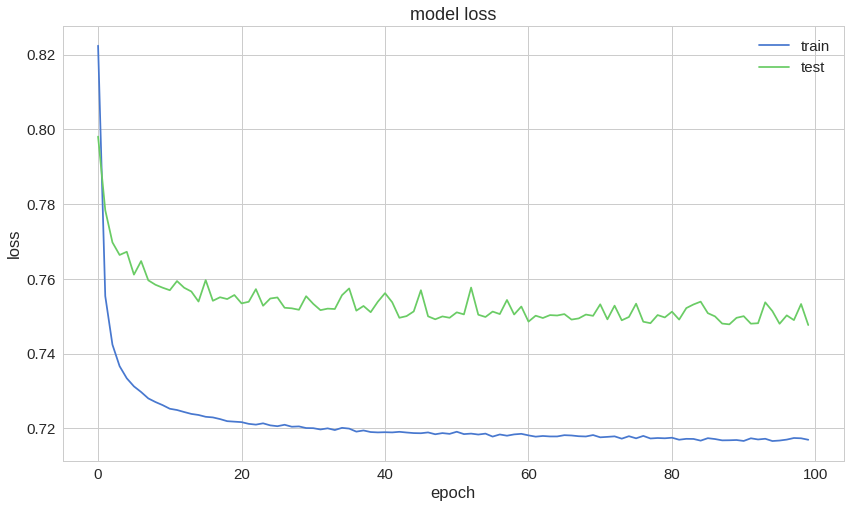

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [32]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.741002,0.001720
std,3.361815,0.041443
min,0.037148,0.000000
25%,0.249564,0.000000
50%,0.408722,0.000000
75%,0.644247,0.000000
max,267.259676,1.000000


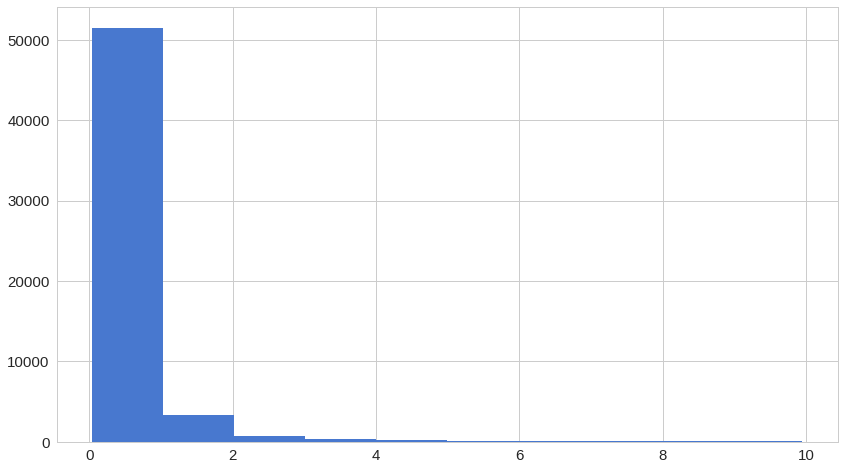

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

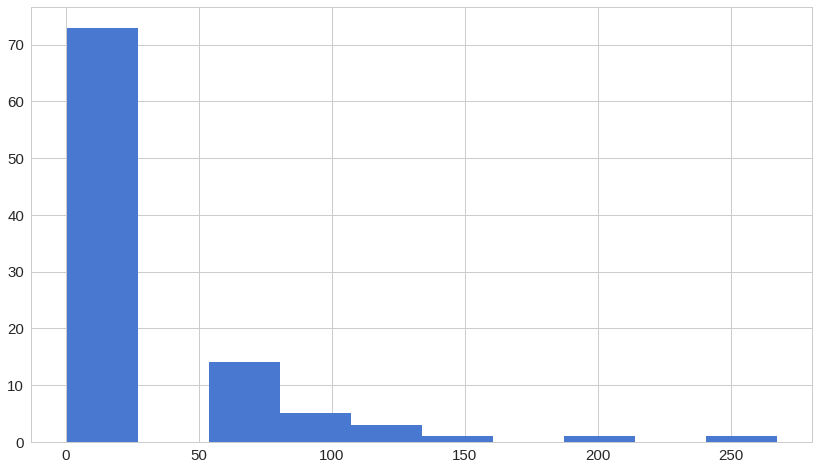

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

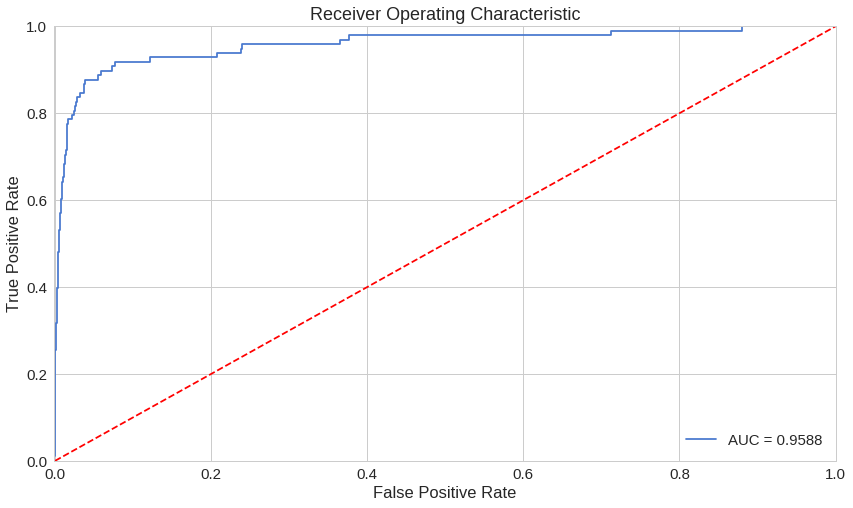

In [36]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

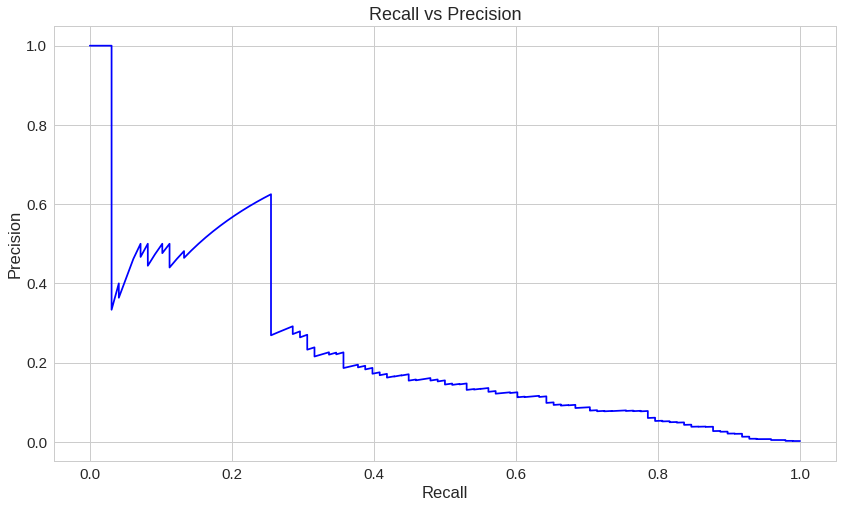

In [37]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

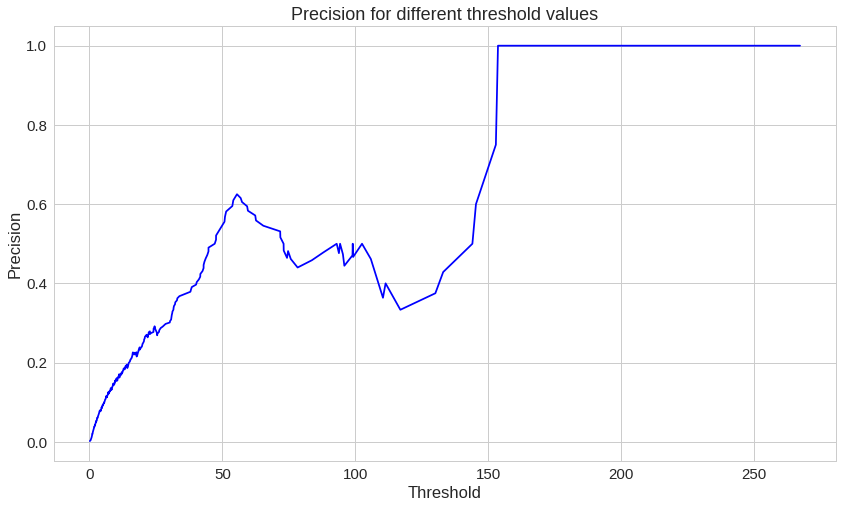

In [38]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

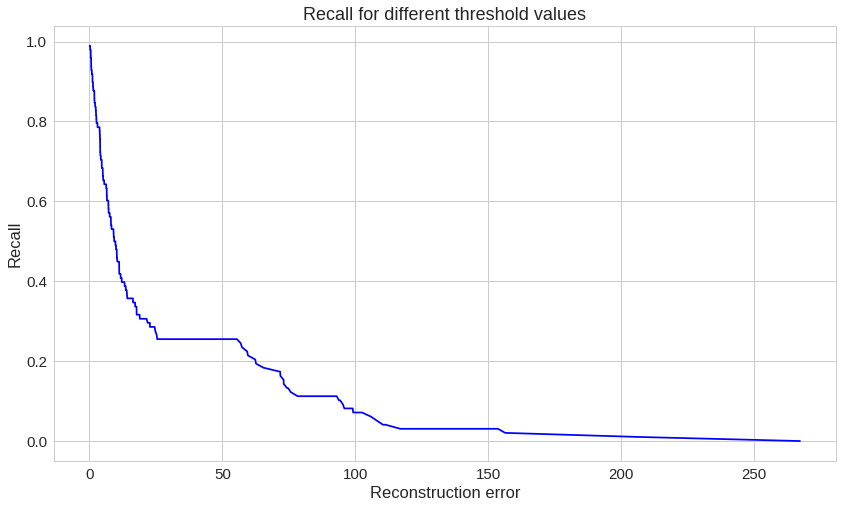

In [39]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [0]:
threshold = 2.9

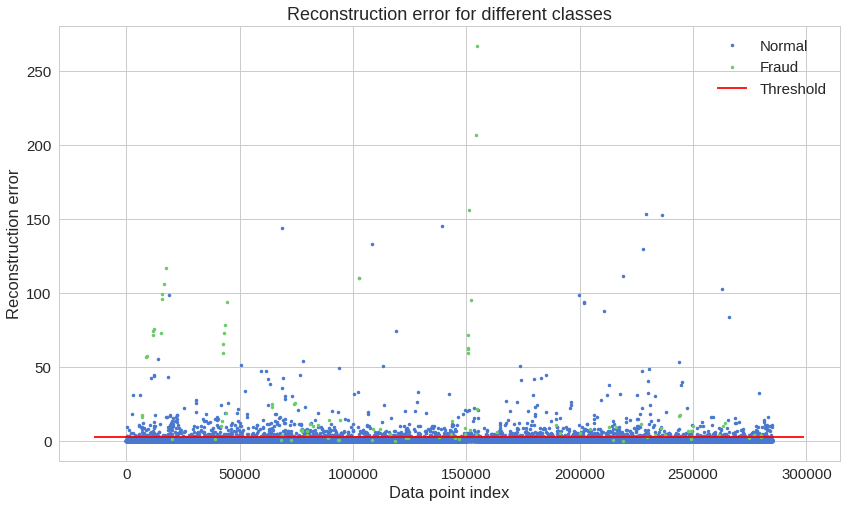

In [41]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

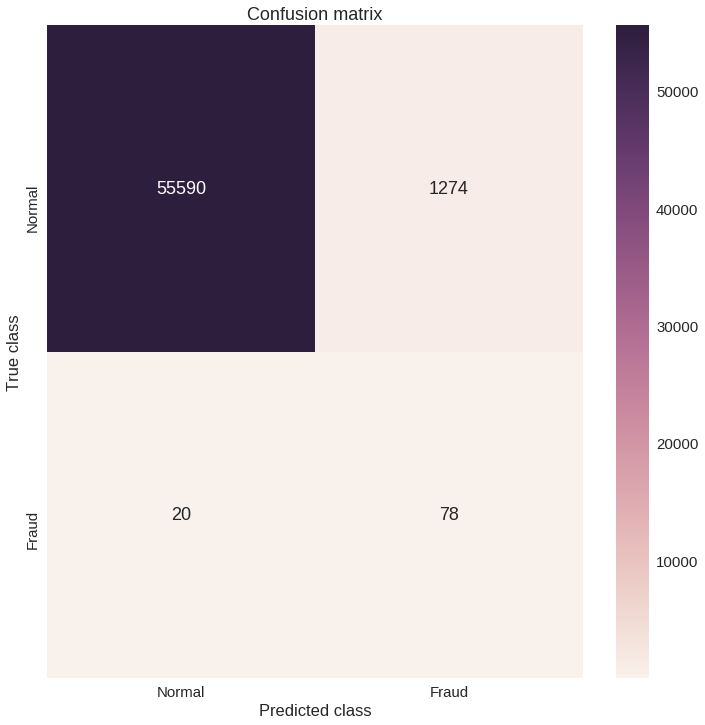

In [42]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()